In [1]:
import os
# import shutil
import pickle

# import time as tm
import datetime

import numpy as np

import pandas as pd
import netCDF4 as nc

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

# import cartopy.crs as ccrs
# from shapely.geometry import Point, shape

from joblib import Parallel, delayed

# import data_mask

import dl_helper as helper


## Load Regional Masks

In [2]:
# TODO: Define the path_to_pkls_folder (where you stored the mask pkls)
group = '1'
pkl_folder = f'group_{group}'

path_to_pkls_folder = os.path.join('..', 'masks', pkl_folder)   

In [3]:
# get a list of .pkl files in path_to_pkls_folder
mask_filenames = [f for f in os.listdir(path_to_pkls_folder) if f.startswith('masked') and f.endswith('.pkl')]
bounding_file = [f for f in os.listdir(path_to_pkls_folder) if f.startswith('bounding') and f.endswith('.pkl')]
print("Masks: \t\t", mask_filenames)
print("Bounding box:\t", bounding_file)

Masks: 		 ['masked_array_region_009.pkl', 'masked_array_region_008.pkl', 'masked_array_region_007.pkl', 'masked_array_region_010.pkl']
Bounding box:	 ['bounding_box.pkl']


In [4]:
masked_arrays = {file.split('.')[-2].split('_')[-1]: pickle.load(open(os.path.join(path_to_pkls_folder, file), 'rb')) for file in mask_filenames}
bounding_box = pickle.load(open(os.path.join(path_to_pkls_folder, bounding_file[0]), 'rb'))

In [5]:
lons, lats = helper.get_lons_lats(bounding_box)

# Check that everything is in order

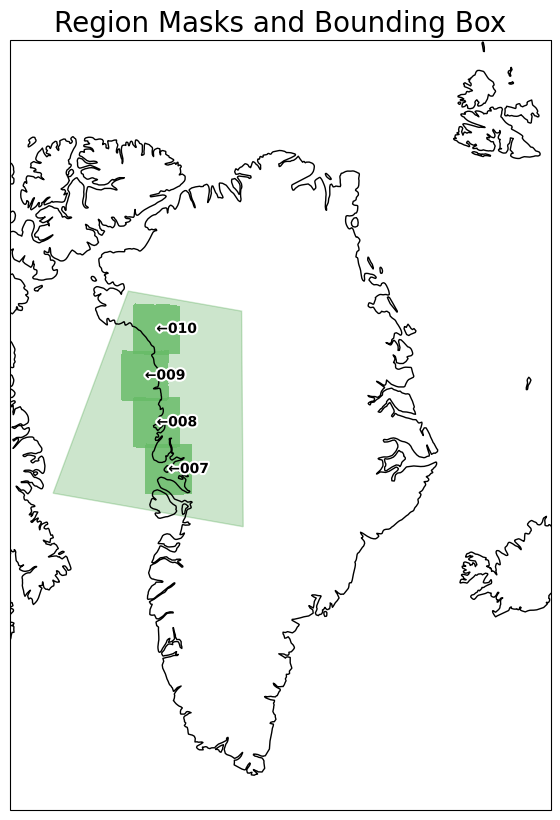

In [6]:
helper.visualize_masks(masked_arrays, lons, lats)

# Define your staging area and destination folder

Data is temporarily written to a temporary (staging) location, then is moved to the destination when the writing is complete.

In [7]:
destination_foldername = f'chla_data_group_{group}'
destination_path = os.path.join('/Volumes/Seagate 5TB/OceanColour Data/', 'regional_chla_data', destination_foldername)
if not os.path.exists(destination_path):
    os.makedirs(destination_path)

temp_path = os.path.join('..', 'data', 'regional_chla_data', 'staging')
if not os.path.exists(temp_path):
    os.makedirs(temp_path)

In [8]:
step, steps_needed = helper.get_steps_remaining(destination_path)

for attempt in range(5):
    try:
        Parallel(n_jobs=-1)(delayed(helper.process_batch)(i, step, bounding_box, lons, lats, destination_path, temp_path) for i in steps_needed)
        break  # If the operation succeeds, break the loop
    except Exception as e:
        print(f"Attempt {attempt+1} failed with error: {e}")
        step, steps_needed = helper.get_steps_remaining(destination_path)
else:
    print("Operation failed after 5 attempts. Quitting.")

# for f in os.listdir(temp_path):
#     os.remove(os.path.join(temp_path, f))

steps, steps_needed = helper.get_steps_remaining(destination_path)
if len(steps_needed) == 0:
    print("All batches have been processed.")
else:
    print(f"{len(steps_needed)} batches are still pending.")
    print("Please run the cell again to process the remaining batches.")

Batches remaining:  192


# Plot the data

### Custom colormap 

In [43]:
def desaturate_colormap(colormap, factor):
    colors = colormap(np.linspace(0, 1, colormap.N))
    hsv_colors = plt.cm.colors.rgb_to_hsv(colors[:, :3])  # Extract RGB values and convert to HSV

    # Desaturate the colors
    hsv_colors[:, 1] *= factor

    # Convert back to RGB
    desaturated_colors = plt.cm.colors.hsv_to_rgb(hsv_colors)

    # Create a new colormap
    desaturated_colormap = LinearSegmentedColormap.from_list(
        f"{colormap.name}_desaturated",
        desaturated_colors,
        colormap.N
    )

    return desaturated_colormap

# Turbo colormap
turbo_colormap = plt.cm.get_cmap("turbo")

# Specify the desaturation factor (0.85 for 15% desaturation)
desaturation_factor = 0.85

# Create desaturated Turbo colormap
desaturated_turbo_colormap = desaturate_colormap(turbo_colormap, desaturation_factor)

# Store the desaturated colormap in a Python list
desaturated_colormap_list = desaturated_turbo_colormap(np.linspace(0, 1, 256)).tolist()

turbo_desat = colors.LinearSegmentedColormap.from_list("", desaturated_colormap_list)


/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_32691/2543794758.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  turbo_colormap = plt.cm.get_cmap("turbo")


In [ ]:
# Given a month, get the indices that correspond to that month

start = 0
end = 9500  
step = 500  
all_indices = []

month = 8

def get_indices_for_given_month(start, end, step, month, all_indices):
    for i in range(start, end, step):
        firstday = str(i)
        lastday = str(i+step-1)
        url = "https://www.oceancolour.org/thredds/dodsC/CCI_ALL-v6.0-1km-DAILY?time["+firstday+":1:"+lastday+"]"
        ds = nc.Dataset(url)
        time = ds.variables['time'][:]

        for j in range(len(time)):
            dates = datetime.date(1970, 1, 1) + datetime.timedelta(days=int(time[j]))
            if (dates.month == month):
                all_indices.append(i+j)

    return all_indices

def group_indicies_by_year(all_indices):
    grouped_indices = []
    current_group = [all_indices[0]]

    for i in range(1, len(all_indices)):
        if all_indices[i] - all_indices[i-1] == 1:
            current_group.append(all_indices[i])
        else:
            grouped_indices.append(current_group)
            current_group = [all_indices[i]]

    # Append the last group
    if current_group:
        grouped_indices.append(current_group)

    return grouped_indices



# TO RUN: UNCOMMENT
# all_indices = get_indices_for_given_month(start, end, step, month, august_indices)
# grouped_indices = group_indicies_by_year(all_indices)

In [3]:
# pickle grouped_indices
# with open('august_indices.pkl', 'wb') as f:
#     pickle.dump(grouped_indices, f)
#     f.close()

with open('august_indices.pkl', 'rb') as f:
    grouped_indices = pickle.load(f)

In [46]:
print(len(grouped_indices))

26


In [9]:
# load in nc.Dataset(f'../chlora_data/august/chlor_a_data_{year} for year in [2002, 2008, 2012, 2019]

years = [2002, 2008, 2012, 2019]
datasets = []

for year in years:
    filepath = f'../chlora_data/august/chlor_a_data_{year}'
    dataset = nc.Dataset(filepath)
    datasets.append(dataset)


In [10]:
from pyproj import Transformer
from pyproj import Proj, transform
def reproject_polygon(polygon_array,inputCRS,outputCRS,x_column=0,y_column=1,run_test = True):

    transformer = Transformer.from_crs('EPSG:' + str(inputCRS), 'EPSG:' + str(outputCRS))

    # There seems to be a serious problem with pyproj
    # The x's and y's are mixed up for these transformations
    #       For 4326->3413, you put in (y,x) and get out (x,y)
    #       For 3413->4326, you put in (x,y) and get out (y,x)
    #       For 326XX->3413, you put in (x,y) and get out (x,y)
    # Safest to run check here to ensure things are outputting as expected with future iterations of pyproj

    if inputCRS == 4326 and outputCRS == 3413:
        x2, y2 = transformer.transform(polygon_array[:,y_column], polygon_array[:,x_column])
        x2 = np.array(x2)
        y2 = np.array(y2)
    elif inputCRS == 3413 and outputCRS == 4326:
        y2, x2 = transformer.transform(polygon_array[:, x_column], polygon_array[:, y_column])
        x2 = np.array(x2)
        y2 = np.array(y2)
    elif str(inputCRS)[:3] == '326' and outputCRS == 3413:
        x2, y2 = transformer.transform(polygon_array[:,x_column], polygon_array[:,y_column])
        x2 = np.array(x2)
        y2 = np.array(y2)
        run_test = False
    else:
        raise ValueError('Reprojection with this epsg is not safe - no test for validity has been implemented')

    if run_test:
        run_reprojection_test(inputCRS,outputCRS)

    output_polygon=np.copy(polygon_array)
    output_polygon[:,x_column] = x2
    output_polygon[:,y_column] = y2
    return output_polygon

In [21]:
# get the average chlorophyll data for each year
chlor_a = datasets[0].variables['chlor_a'][:]
time_var = datasets[0].variables['time'][:]
average = np.nanmean(chlor_a, axis=0) 

# output_poly = reproject_polygon(average,4326,3413, x_column=0,y_column=1,run_test = False)



/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_32691/1540193662.py:4: RuntimeWarning: Mean of empty slice
  average = np.nanmean(chlor_a, axis=0)


In [23]:
output_poly = reproject_polygon(average,4326,3413, x_column=0,y_column=1,run_test = False)

In [58]:
def store_plots(ds):

    chlor_a = ds.variables['chlor_a'][:]
    time_var = ds.variables['time'][:]
    average = np.nanmean(chlor_a, axis=0) 
    
    figsize = (8, 10)
    plt.figure(figsize=figsize, dpi=400)

    C =plt.pcolormesh(average, vmin=0.5, vmax=4, cmap = turbo_desat)

    plt.title(f'August {get_mmddyy(time_var[0]).tm_year}', fontsize=20, weight='bold')
    plt.gca().invert_yaxis()  # Invert y-axis

    plt.xticks([])
    plt.yticks([])

    cbar = plt.colorbar(C)
    cbar.set_label('$mg/m^3$', size=16, weight='bold')  # Set colorbar label font size and weight
    cbar.ax.tick_params(labelsize=16)  # Set tick label font size

    # Set color bar tick labels to bold
    for l in cbar.ax.yaxis.get_ticklabels():
        l.set_weight("bold")


    plt.savefig(f"../figures/august_means/august_{get_mmddyy(time_var[0]).tm_year}", dpi=400, transparent=True)
    # plt.show()
    plt.close()


for year in range(1998, 2024):
    filepath = f'../chlora_data/august/chlor_a_data_{year}'
    store_plots(nc.Dataset(filepath))

In [ ]:
# Inspect the data in the directory ../means
def inspect_data(directory):
    directory = '../means/'
    df = pd.DataFrame()

    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            temp_df = pd.read_csv(filepath)
            df = pd.concat([df, temp_df])

    df['mean'] = df['mean'].replace('--', np.nan)
    df['region'] = df['region'].astype('category')
    df['datetime'] = pd.to_datetime(df['time'], unit='D', origin='1970-01-01')
    df['year'] = df['datetime'].dt.year
    df['mean'] = df['mean'].astype(float)

    return df
   

# Print the combined DataFrame
# print(inspect_data('../means'))